<a href="https://colab.research.google.com/github/Tom-Jung/ML_Colab/blob/main/28_Transfer_Learning_exam(catsanddogs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#  파일 다운로드
!wget = storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-03-25 20:54:38--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2022-03-25 20:54:38--  http://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 108.177.125.128, 2404:6800:4008:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  43.4MB/s    in 1.5s    

2022-03-25 20:54:40 (43.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

FINISHED --2022-03-25 20:54:40--
Total wall clock time: 2.5s
Downloaded: 1 files, 65M in 1.5s (43.4 MB/s)


In [21]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

/content/cats_and_dogs_filtered/  is removed !!!


In [4]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/')

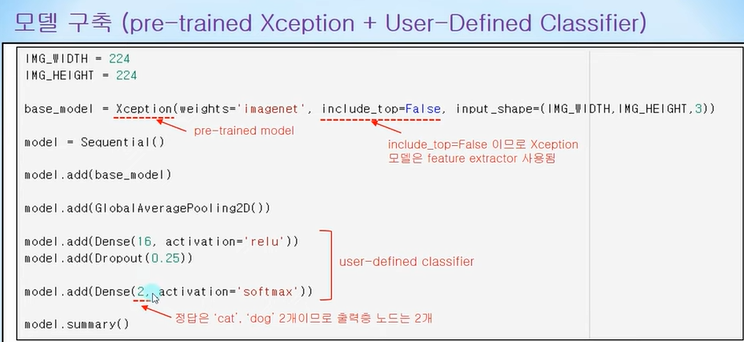

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT,3))

model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non

In [6]:
train_dir ='/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
test_dir ='/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

train_data_gen = ImageDataGenerator(rescale=1./225, rotation_range=0, width_shift_range=0.1, 
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)
test_data_gen = ImageDataGenerator(rescale=1./255)

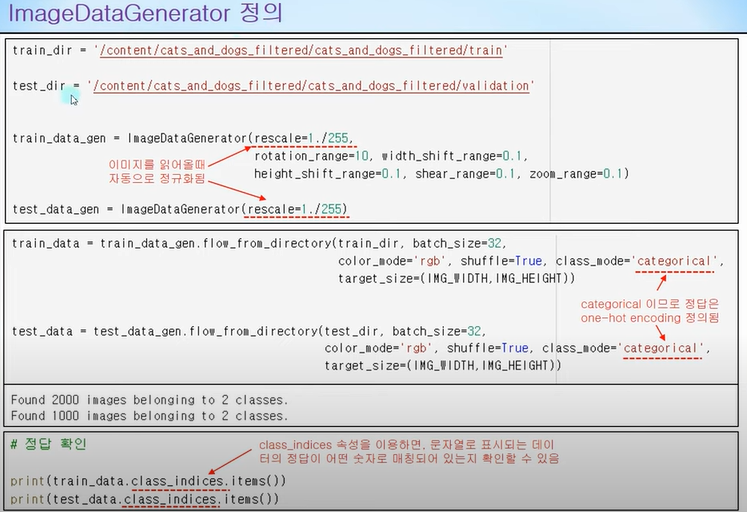

In [7]:
train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32,
                                                              color_mode='rgb', shuffle=True, class_mode='categorical',
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32,
                                                              color_mode='rgb', shuffle=True, class_mode='categorical',
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
print(train_data.class_indices.items())
print(test_data.class_indices.items())

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])


In [9]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [10]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       
                             monitor='val_loss',   
                             verbose=1,            
                             save_best_only=True,  
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss',  
                              patience=5,          
                             )


start_time = datetime.now()

hist = model.fit(train_data, epochs=30, 
                 validation_data=test_data,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4595 - accuracy: 0.8300
Epoch 1: val_loss improved from inf to 0.12231, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 113s 2s/step - loss: 0.4595 - accuracy: 0.8300 - val_loss: 0.1223 - val_accuracy: 0.9730
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.9545
Epoch 2: val_loss improved from 0.12231 to 0.05545, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 93s 1s/step - loss: 0.1827 - accuracy: 0.9545 - val_loss: 0.0554 - val_accuracy: 0.9810
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9840
Epoch 3: val_loss improved from 0.05545 to 0.04792, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 92s 1s/step - loss: 0.0926 - accuracy: 0.9840 - val_loss: 0.0479 - val_accuracy: 0.9810
E

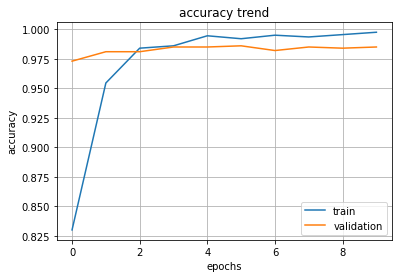

In [11]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

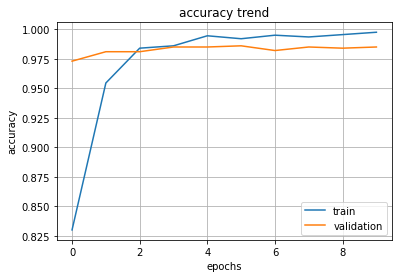

In [12]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

In [32]:
import os
import shutil

if os.path.exists('C:/Users/Jung_y/test_image_dir'):    
    
    shutil.rmtree('C:/Users/Jung_y/test_image_dir')
    print('/content/test_image_dir/  is removed !!!')

In [49]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/test_image_dir.zip', 'r') as target_file:

    target_file.extractall('/content/test_image_dir/')

FileNotFoundError: ignored

In [50]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('test_image_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

[]
0


In [37]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

<Figure size 576x432 with 0 Axes>

In [18]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

In [19]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(0,)


In [20]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

ValueError: ignored